The paper: https://doi.org/10.1016/j.ibmed.2024.100188

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as display
from PIL import Image
from tqdm import tqdm
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tfk.__version__)
print("Is GPU detected: ", len(tf.config.list_physical_devices('GPU'))>0)

Tensorflow version:  2.17.1
Keras version:  3.5.0
Is GPU detected:  True


In [2]:
tfk.mixed_precision.set_global_policy("mixed_float16")

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


## Load dataset

In [5]:
data = np.load('/kaggle/input/lung-cancer/lung_dataset_interpolated.npz')
full_slices = data['full_slices']
nodules = data['nodules']
tumor_classes = data['tumor_classes']

In [6]:
del data

In [7]:
def transform_labels_to_binary(labels, threshold=3): 
    new_labels = [0 if label <= threshold else 1 for label in labels]
    return np.array(new_labels)

In [8]:
tumor_classes = transform_labels_to_binary(tumor_classes)

In [9]:
print("full_slices shape: ", full_slices.shape)
print("nodules shape: ", nodules.shape)
print("tumor_classes shape: ", tumor_classes.shape)

full_slices shape:  (2363, 512, 512)
nodules shape:  (2363, 138, 138)
tumor_classes shape:  (2363,)


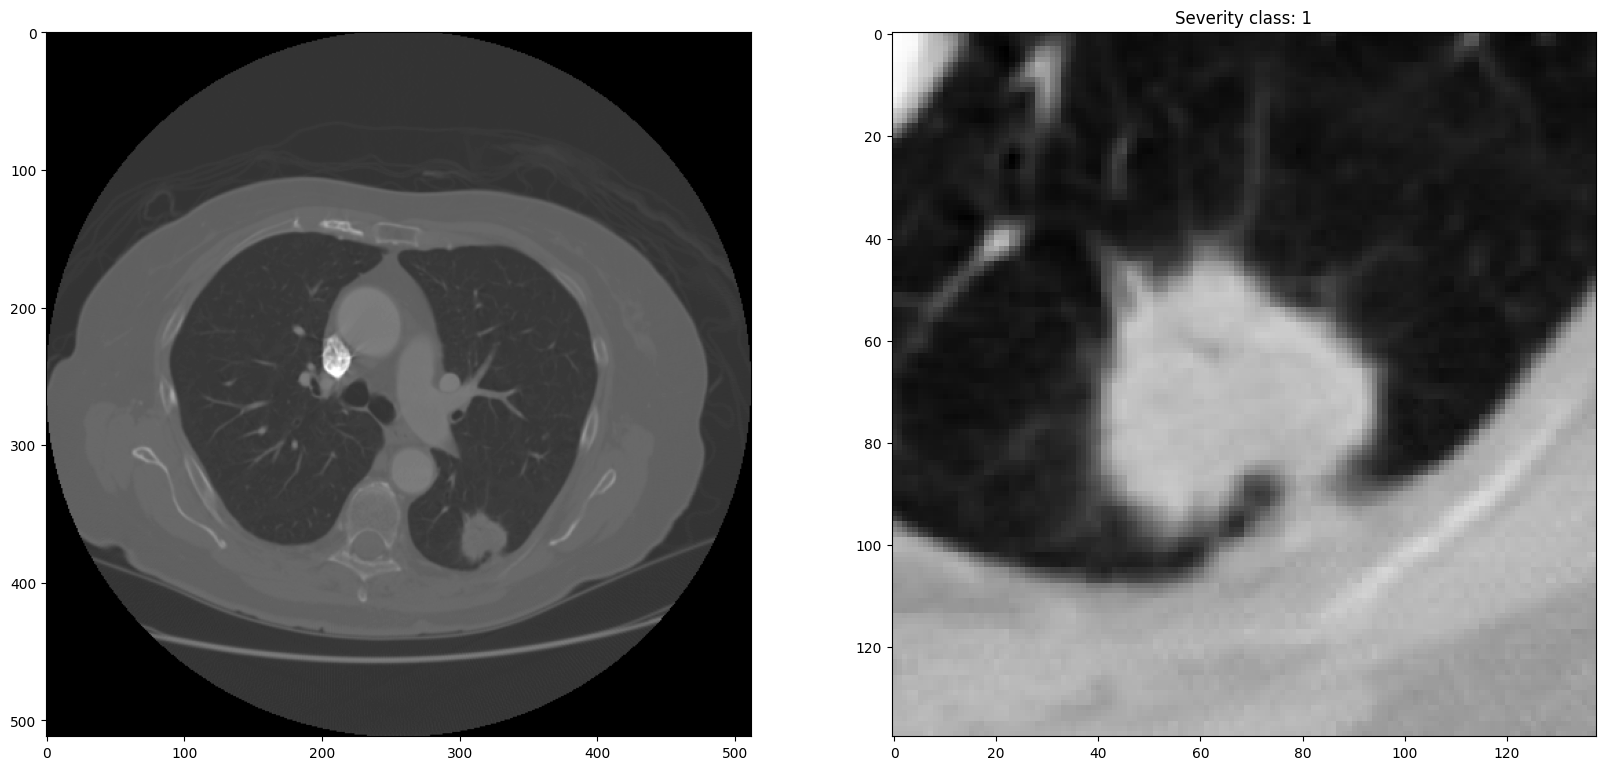

In [10]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {tumor_classes[IMAGE_IDX]}")

ax1.imshow(full_slices[IMAGE_IDX], cmap='gray')
ax2.imshow(nodules[IMAGE_IDX], cmap='gray')

plt.show()

# Data preprocessing

In [11]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) -  np.min(x))

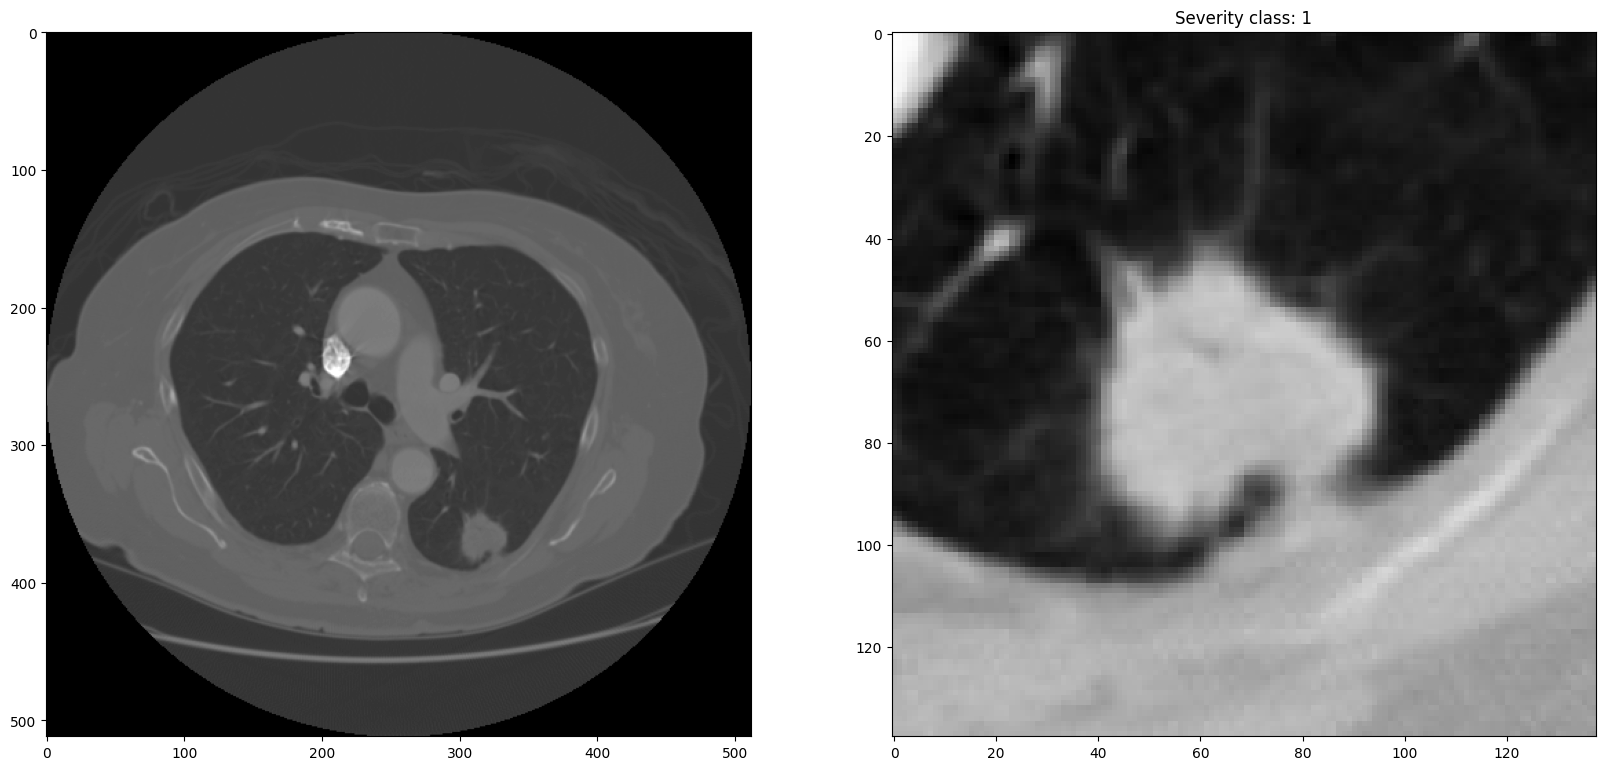

In [12]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {tumor_classes[IMAGE_IDX]}")

ax1.imshow(normalize(full_slices[IMAGE_IDX]), cmap='gray')
ax2.imshow(normalize(nodules[IMAGE_IDX]), cmap='gray')

plt.show()

In [13]:
# Normalize to values between 0 and 255
for i in range(full_slices.shape[0]):
    full_slices[i] = np.ceil(normalize(full_slices[i])*255)
full_slices = full_slices.astype("uint8")

<ipython-input-11-d496c61a2539>:2: RuntimeWarning: overflow encountered in scalar subtract
  return (x - np.min(x)) / (np.max(x) -  np.min(x))


In [14]:
import cv2 as cv

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    return img

def img_enhancer_logger(img):
    def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    plot_image(img)
    img = cv.medianBlur(img, 3)
    plot_image(img)
    img = cv.equalizeHist(img)
    plot_image(img)
    img = clahe.apply(img)
    plot_image(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img)
    return img

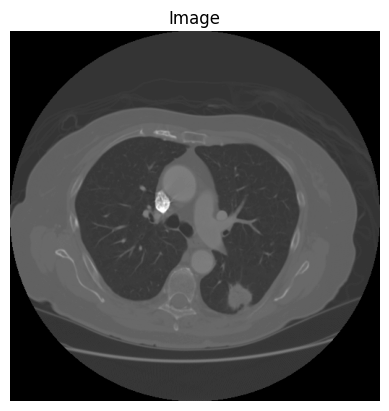

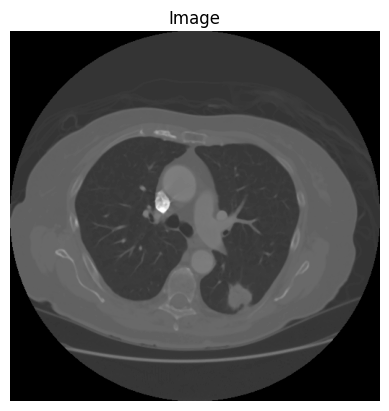

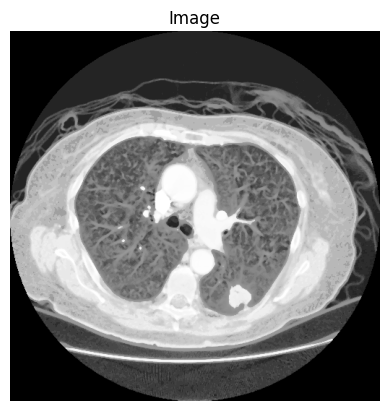

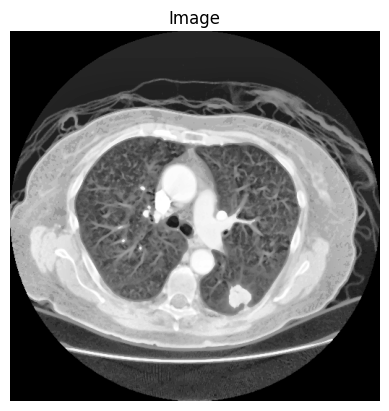

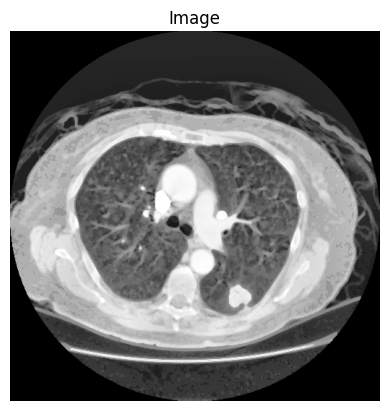

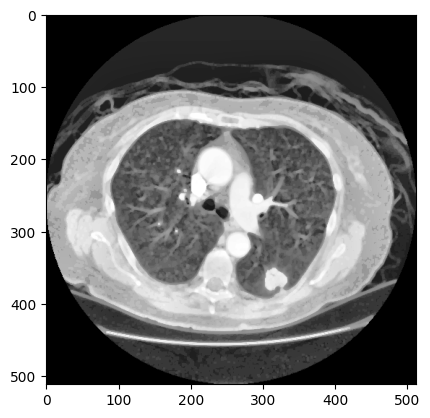

In [15]:
plt.title('After "enhancements"')
plt.imshow(img_enhancer_logger(full_slices[IMAGE_IDX]), cmap='gray')
plt.show()

In [16]:
# Enhance the images

processed_images = []
for img in full_slices:
    img = img_enhancer(img)
    processed_images.append(img)

full_slices = np.array(processed_images)

In [17]:
# subtract 1 from the class encoding because to_categorical expects starting index = 0
label_set = tfk.utils.to_categorical(tumor_classes)
label_set

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [18]:
def calculate_class_weight(Y):
    from sklearn.utils.class_weight import compute_class_weight

    y_integers = np.argmax(Y, axis=1)
    return compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)    

[0.65895148 2.07280702]


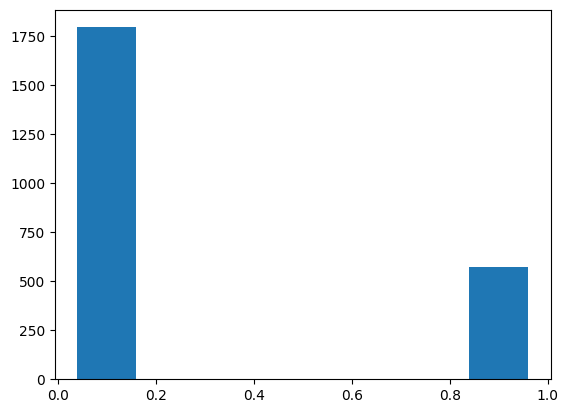

In [19]:
# Starting class weights (inverse frequencies)
class_weights = calculate_class_weight(label_set)

plt.hist(np.argmax(label_set, -1), bins=5,rwidth=0.6)
print(class_weights)

# d_class_weights = dict(enumerate(class_weights))

# import json # Just to prettify the debug
# print(json.dumps(d_class_weights, sort_keys=True, indent=1))

[0.97685443 1.02426901]
{
 "0": 0.9768544339096487,
 "1": 1.024269005847953
}


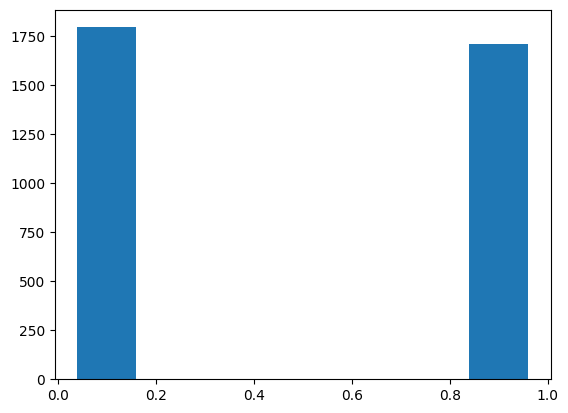

In [20]:
# Balance the dataset by applying random rotations
full_slices = np.expand_dims(full_slices, -1)

X_bal, y_bal = [], []
X_bal.extend(full_slices)
y_bal.extend(label_set)

while class_weights[1] > 1 + 0.1:
    # Repeat this while last class (the minority one) is "infrequent"
    for x, y in zip(full_slices, label_set):
        
        # Apply augmentation if class is infrequent
        if class_weights[np.argmax(y)] > 1:
            # Just rotation to not mess up too much the image distribution (thankfully they're only slices of the CT) 
            x = tfkl.RandomRotation(0.9)(x)
            X_bal.append(x)
            y_bal.append(y)
    
    # Recalculate weights
    class_weights = calculate_class_weight(y_bal)

X_balanced, y_balanced = np.asarray(X_bal), np.asarray(y_bal)

plt.hist(np.argmax(y_balanced, -1), bins=5,rwidth=0.6)
print(class_weights)


# These lines are now useless but ok
d_class_weights = dict(enumerate(class_weights))

import json # Just to prettify the debug
print(json.dumps(d_class_weights, sort_keys=True, indent=1))

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, shuffle=True)

X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

print("Train/Test mins ", np.min(X_train), np.min(X_test))
print("Train/Test maxs ", np.max(X_train), np.max(X_test))

Training set shape:  (2452, 512, 512, 1) (2452, 2)
Test set shape:  (1051, 512, 512, 1) (1051, 2)
Train/Test mins  0.0 0.0
Train/Test maxs  1.0 1.0


In [22]:
del X_balanced, y_balanced

In [23]:
def perform_augmentation(X, Y, p):
    X_aug, y_aug = [], []
    for x, y in tqdm(zip(X, Y), total=len(X), desc="Augmenting data"):
        X_aug.append(x)
        y_aug.append(y)

        if np.random.random() < p: # random rotate the image and add it
            # It would be better to apply these independently
            x = tfkl.RandomRotation(0.9)(x)
            x = tfkl.RandomFlip()(x)
            x = tfkl.RandomTranslation(0.3, 0.3)(x)
            X_aug.append(x)
            y_aug.append(y)

    return np.asarray(X_aug), np.asarray(y_aug)

In [24]:
# Repeated training set augmentation for laughs
# X_aug, y_aug = perform_augmentation(X_train, y_train, 0.75)
# X_aug, y_aug = perform_augmentation(X_aug, y_aug, 0.2)

# print("Augmented training set shape: ", X_aug.shape, y_aug.shape)

## Model definition

In [25]:
def inception_block(inputs, filters, name):
    f1, f3, f5, fpool = filters

    # 1x1 convolution
    conv_1x1 = tfkl.Conv2D(f1, kernel_size=1, activation='relu', name=f"{name}_1x1_conv")(inputs)

    # 3x3 convolution
    conv_3x3 = tfkl.Conv2D(f3, kernel_size=3, padding='same', activation='relu', name=f"{name}_3x3_conv")(inputs)

    # Max pooling followed by 1x1 convolution
    max_pool = tfkl.MaxPooling2D(pool_size=3, strides=1, padding='same', name=f"{name}_max_pool")(inputs)
    max_pool = tfkl.Conv2D(fpool, kernel_size=1, activation='relu', name=f"{name}_pool_1x1_conv")(max_pool)

    # Concatenate all outputs
    output = tfkl.Concatenate(name=f"{name}_concat")([conv_1x1, conv_3x3, max_pool])
    return output

def build_model(filters):
    f1, f2, f3, f4 = filters

    inputs = tfkl.Input(shape=(512, 512, 1), name='input')

    # Initial convolution
    x = tfkl.Conv2D(f1, kernel_size=3, activation='relu', name="conv_initial")(inputs)
    x = tfkl.MaxPooling2D(name="max_pool_initial")(x)

    # Inception block 1
    x = inception_block(x, [f1, f2, f3, f4], name="inception_1")
    x = tfkl.SpatialDropout2D(0.2, name="spatial_dropout_1")(x)

    # Inception block 2
    x = inception_block(x, [f2, f3, f4, f1], name="inception_2")
    x = tfkl.SpatialDropout2D(0.3, name="spatial_dropout_2")(x)

    # Global pooling and final classification
    x = tfkl.GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = tfkl.Dense(256, activation="silu")(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(2, activation="softmax", name="output")(x)

    model = tfk.Model(inputs=inputs, outputs=x, name="inception_model")
    model.summary(expand_nested=True, show_trainable=True)
    return model

In [26]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [27]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [28]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', 
    patience=50,
    restore_best_weights=True
)

In [29]:
with strategy.scope():
    model = build_model(filters=(64, 64, 128, 256))
    model.compile(
        loss=tfk.losses.CategoricalFocalCrossentropy(alpha=list(d_class_weights.values())),
        optimizer=tfk.optimizers.AdamW(),
        metrics=['accuracy', 'recall']
    )

Model: "inception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)     │ (None, 512, 512, 1)  │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ cast (Cast)            │ (None, 512, 512, 1)  │            0 │ input[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_initial (Conv2D)  │ (None, 510, 510, 64) │          640 │ cast[0][0]          │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pool_initial       │ (None, 255, 255, 64) │            0 │ conv_initial[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_1_max_pool   │ (None, 255, 255, 64) │            0 │ max_pool_initial[0… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_1_1x1_conv   │ (None, 255, 255, 64) │        4,160 │ max_pool_initial[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_1_3x3_conv   │ (None, 255, 255, 64) │       36,928 │ max_pool_initial[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_1_pool_1x1_… │ (None, 255, 255,     │       16,640 │ inception_1_max_po… │    Y    │
│ (Conv2D)               │ 256)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_1_concat     │ (None, 255, 255,     │            0 │ inception_1_1x1_co… │    -    │
│ (Concatenate)          │ 384)                 │              │ inception_1_3x3_co… │         │
│                        │                      │              │ inception_1_pool_1… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ spatial_dropout_1      │ (None, 255, 255,     │            0 │ inception_1_concat… │    -    │
│ (SpatialDropout2D)     │ 384)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_2_max_pool   │ (None, 255, 255,     │            0 │ spatial_dropout_1[… │    -    │
│ (MaxPooling2D)         │ 384)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_2_1x1_conv   │ (None, 255, 255, 64) │       24,640 │ spatial_dropout_1[… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_2_3x3_conv   │ (None, 255, 255,     │      442,496 │ spatial_dropout_1[… │    Y    │
│ (Conv2D)               │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_2_pool_1x1_… │ (None, 255, 255, 64) │       24,640 │ inception_2_max_po… │    Y    │
│ (Conv2D)             

 Total params: 616,450 (2.35 MB)

 Trainable params: 616,450 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

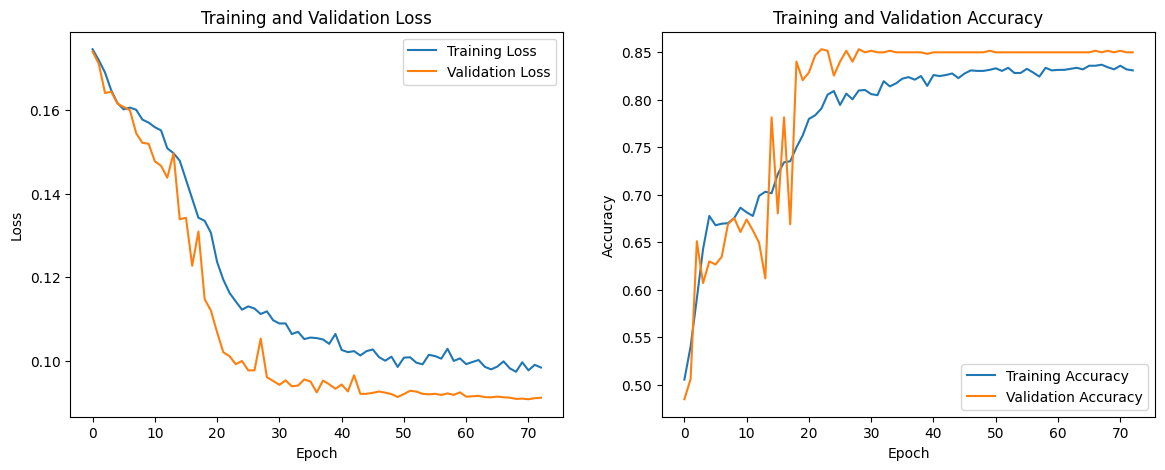

230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - accuracy: 0.8321 - loss: 0.0970 - recall: 0.8321 - val_accuracy: 0.8499 - val_loss: 0.0912 - val_recall: 0.8499


In [30]:
history = model.fit(
    X_train, 
    y_train,
    epochs=1000,
    validation_split = 0.25, 
    batch_size=8,
    shuffle=True,
    callbacks=[early_stopping, RealTimePlot(), CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-8)],
    verbose=1
).history

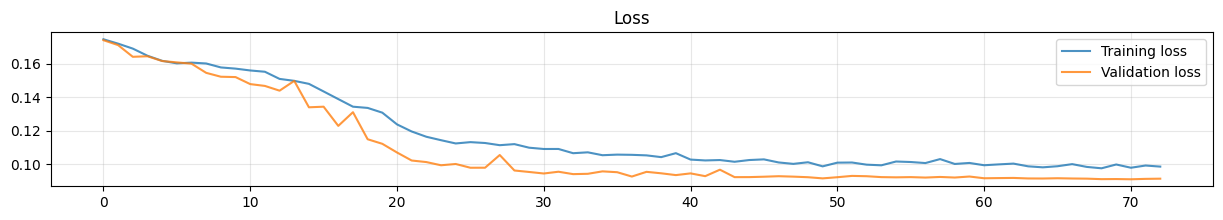

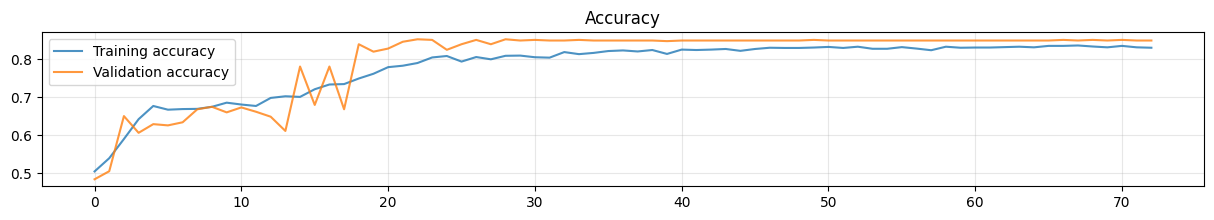

In [31]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [32]:
print(X_test.shape)
print(y_test.shape)
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test, verbose=1)
accuracy = round(test_accuracy, 4)
recall = round(test_recall, 4)
print(f'Test Accuracy: {accuracy}')
print(f'Test Recall: {recall}')

model.save(f"/kaggle/working/CustomCNN_{accuracy}.keras")

(1051, 512, 512, 1)
(1051, 2)
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 776ms/step - accuracy: 0.8140 - loss: 0.1097 - recall: 0.8140
Test Accuracy: 0.8116
Test Recall: 0.8116


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step
Accuracy score over the test set: 0.6775
Precision score over the test set: 0.6972
Recall score over the test set: 0.6775
F1 score over the test set: 0.6705


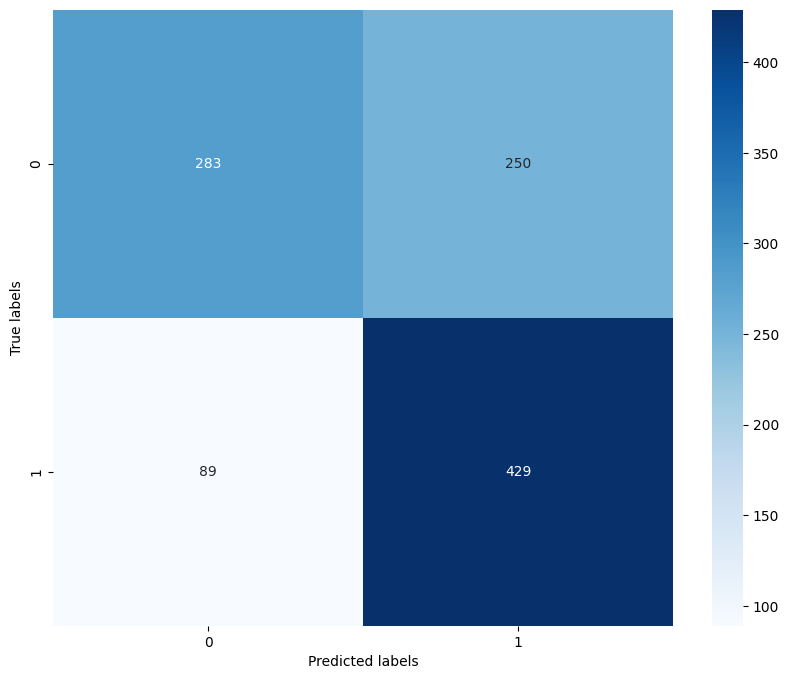

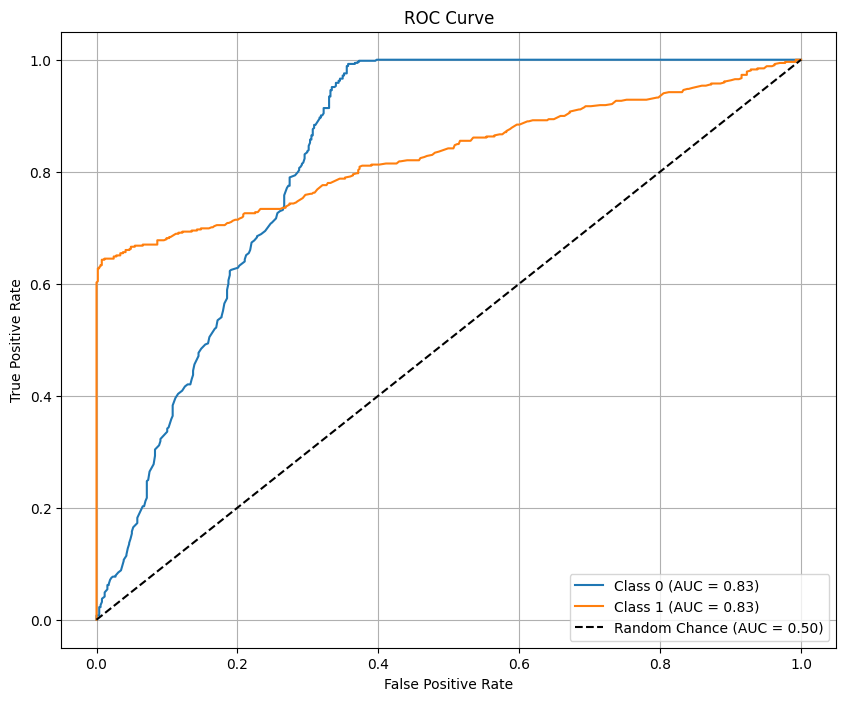

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

classes = [0, 1]

predictions = model.predict(X_test)

threshold = 0.4

pred_classes = (predictions[:, 1] > threshold).astype(int)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Plot ROC curve
# For each class, get true labels and predicted probabilities
true_classes_binarized = y_test  # Ground truth already in one-hot format
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.50)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Test time augmentation

Six sacrifices to Scylla

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
Accuracy score over the test set: 0.588
Precision score over the test set: 0.6315
Recall score over the test set: 0.588
F1 score over the test set: 0.5553


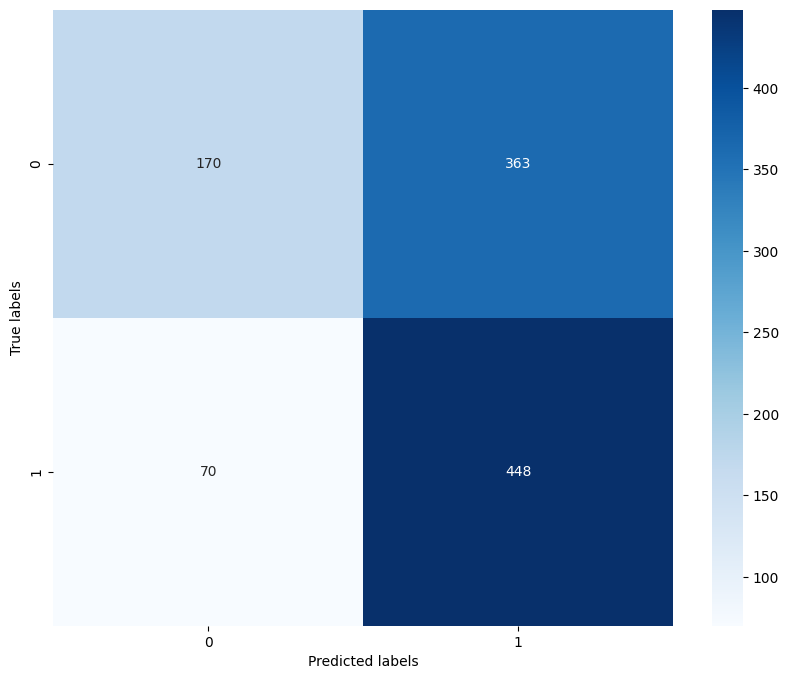

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import mode
import albumentations as A

# Define classes
classes = [0, 1]

# Define TTA augmentations pipeline
def apply_tta_augmentations(image, num_augmentations=6):
    # Random combination of flipping, rotation, and translation
    tta_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=1.0),
    ])
    
    augmented_images = []
    for _ in range(num_augmentations):
        augmented = tta_transform(image=image)
        augmented_images.append(augmented['image'])
    return augmented_images

# Apply TTA to the test set
def test_time_augmentation(X, num_augmentations=6):
    tta_images = []
    for image in X:
        # Convert image to uint8 if necessary (albumentations expects this)
        image = (image * 255).astype(np.uint8) if image.max() <= 1 else image
        # Add the original image + augmented images
        tta_images.append([image] + apply_tta_augmentations(image, num_augmentations))
    return np.array(tta_images)  # Shape: (num_samples, num_augmentations + 1, height, width, channels)

# Prepare the TTA images
num_augmentations = 6
tta_images = test_time_augmentation(X_test, num_augmentations=num_augmentations)

threshold = 0.4

# Predict for each augmented copy
tta_predictions = []
for i in range(tta_images.shape[1]):  # Iterate over the original and augmented versions
    predictions = model.predict(tta_images[:, i])  # Predict for the i-th augmented version
    tta_predictions.append((predictions[:, 1] > threshold).astype(int))  # Convert predictions to class labels

# Majority voting
tta_predictions = np.array(tta_predictions)  # Shape: (num_augmentations + 1, num_samples)
final_predictions = mode(tta_predictions, axis=0).mode.flatten()

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set metrics
accuracy = accuracy_score(true_classes, final_predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, final_predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, final_predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(true_classes, final_predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, final_predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
